# Exploratory Data Analysis

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To get an initial glimpse at dimensionality and formats throughout our train set, let's firstly look at its `shape` and the first few records inside.

In [46]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0')
train.shape

(814262, 11)

In [38]:
train.tail(10)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
814252,ffff74ab47d4fa20695231ce8a293c98_1,traj_ffff74ab47d4fa20695231ce8a293c98_1_1,12:03:01,12:03:01,NaN,NaN,NaN,3.765571e+06,-1.917242e+07,3.765571e+06,-1.917242e+07
814253,ffff74ab47d4fa20695231ce8a293c98_1,traj_ffff74ab47d4fa20695231ce8a293c98_1_2,12:15:33,12:15:33,NaN,NaN,NaN,3.766056e+06,-1.917500e+07,3.766056e+06,-1.917500e+07
814254,ffff74ab47d4fa20695231ce8a293c98_1,traj_ffff74ab47d4fa20695231ce8a293c98_1_3,15:08:19,15:08:19,NaN,NaN,NaN,3.756879e+06,-1.911155e+07,3.756879e+06,-1.911155e+07
814255,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_0,00:15:26,00:15:26,NaN,NaN,NaN,3.744753e+06,-1.925588e+07,3.744753e+06,-1.925588e+07
814256,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_3,02:02:17,02:02:17,NaN,NaN,NaN,3.744732e+06,-1.925614e+07,3.744732e+06,-1.925614e+07
814257,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_4,02:21:11,02:21:11,NaN,NaN,NaN,3.744666e+06,-1.925679e+07,3.744666e+06,-1.925679e+07
814258,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_5,06:02:17,06:02:17,NaN,NaN,NaN,3.744732e+06,-1.925614e+07,3.744732e+06,-1.925614e+07
814259,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_7,09:52:13,09:52:13,NaN,NaN,NaN,3.744666e+06,-1.925679e+07,3.744666e+06,-1.925679e+07
814260,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_8,14:20:26,14:27:15,NaN,NaN,NaN,3.741043e+06,-1.929051e+07,3.741057e+06,-1.928936e+07
814261,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_10,14:56:46,15:04:05,0.0,0.0,0.0,3.743948e+06,-1.923560e+07,3.744842e+06,-1.926218e+07


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 814262 entries, 0 to 814261
Data columns (total 11 columns):
hash             814262 non-null object
trajectory_id    814262 non-null object
time_entry       814262 non-null object
time_exit        814262 non-null object
vmax             256769 non-null float64
vmin             256769 non-null float64
vmean            270778 non-null float64
x_entry          814262 non-null float64
y_entry          814262 non-null float64
x_exit           814262 non-null float64
y_exit           814262 non-null float64
dtypes: float64(7), object(4)
memory usage: 74.5+ MB


We can already identify a couple of trajectories, time marks and positioning - yet it wouldn't be possible to conclude much. Glancing the `.head` of a dataset can only bring a general idea of data format.

In order to trace a broader analysis of `train.csv`'s content, we will be using the `pandas_profiling` lib, which can give us a full report on missing value percentage per column, correlation scores and other metrics.

In [6]:
import pandas_profiling

pandas_profiling.ProfileReport(train)

Number of variables,11
Number of observations,814262
Total Missing (%),6.2%
Total size in memory,74.5 MiB
Average record size in memory,96.0 B
Numeric,4
Categorical,3
Boolean,0
Date,0
Text (Unique),1
Rejected,3


Visualizing the trajectory from a single ID in a day can give us a more focused view into the dataset's scenario representation.

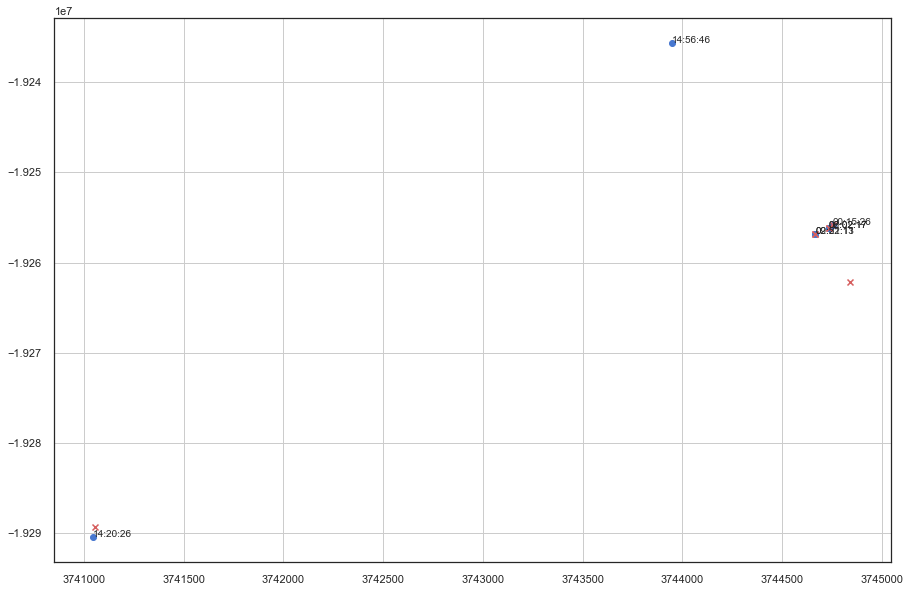

In [48]:
sample = train[train.hash == 'ffffc6359725f0e1feac9ef1872ab207_11']

fig = plt.figure(figsize=(15, 10))

plt.scatter(sample.x_entry, sample.y_entry, c='b', marker='o')
plt.scatter(sample.x_exit, sample.y_exit, c='r', marker='x')

for i, txt in enumerate(sample.time_entry):
    plt.annotate(txt, (sample.x_entry.iloc[i], sample.y_entry.iloc[i]))
    
plt.grid()

Since we're analysing series of trajectories, calculating the euclidian distances between entry and exit points is clearly an important step. Let's get to it.

In [49]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

train['distance'] = euclidian_distance(train.x_entry.values, train.y_entry.values,
                                       train.x_exit.values, train.y_exit.values)

train['distance'].head(4)

0    42364.863118
1     2989.643628
2      725.658561
3     1804.576849
Name: distance, dtype: float64

Exploring the distance variable in a bit more depth, we can group it by `hash` to isolate one-day trajectories.

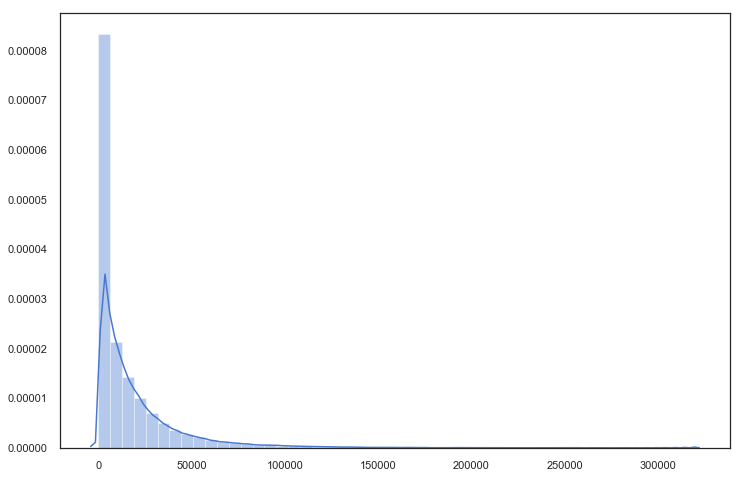

In [50]:
train_grouped = train.groupby('hash').distance

fig = plt.figure(figsize=(12, 8))
sns.set(style="white", palette="muted", color_codes=True)


sns.distplot(train_grouped.mean().dropna().values)

In [51]:
print('Skewness: {}'.format(train_grouped.mean().skew()))
print('Kurtosis: {}'.format(train_grouped.mean().kurtosis()))

Skewness: 3.239516180638298
Kurtosis: 15.702846424196066


As we can see, on average the distance traveled is a little skewed towards the right tail.

We also can explore distance in the time domain, I want to investigate in which time of the day the trajectories has longest distances.

In [52]:
def plot_avg_distance(avg_list, figsize, title='Average Distance Traveled', labels=[]):
    ax = plt.subplot(len(avg_list), 1, 1)
    ax.set_ylabel(title)

    if labels is not None and len(labels) == len(avg_list):
        for avg, label in zip(avg_list, labels):
            avg.plot(ax=ax, figsize=figsize, label=label)
    else:
        for avg in avg_list:
            avg.plot(ax=ax, figsize=figsize)
        
    plt.legend()

Minimum value for time_entry: 0 days 00:00:00
Maximum value for time_entry: 0 days 16:00:00
Minimum value for time_exit: 0 days 00:00:00
Maximum value for time_exit: 0 days 16:00:00


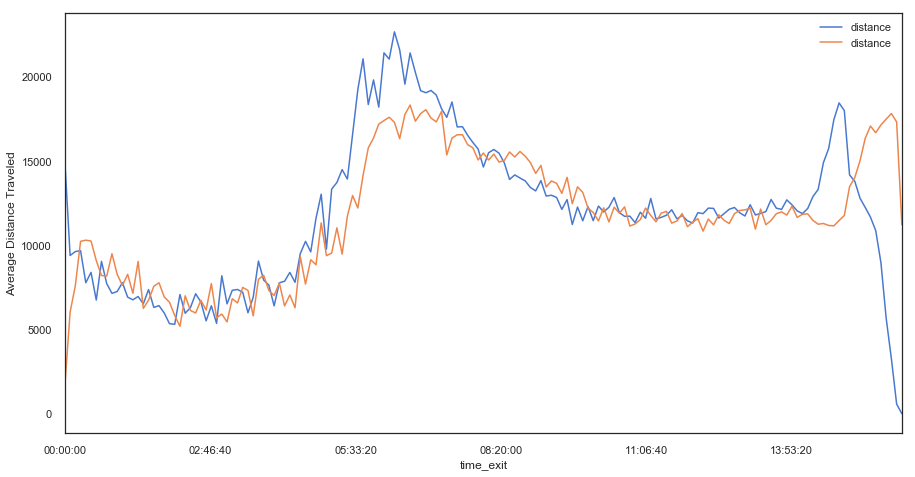

In [53]:
# transforming our time data to pandas timedelta format
train['time_entry'] = pd.to_timedelta(train.time_entry)
train['time_exit'] = pd.to_timedelta(train.time_exit)

print('Minimum value for time_entry: {}'.format(train.time_entry.min()))
print('Maximum value for time_entry: {}'.format(train.time_entry.max()))

print('Minimum value for time_exit: {}'.format(train.time_entry.min()))
print('Maximum value for time_exit: {}'.format(train.time_entry.max()))

entry_avg = train.set_index('time_entry').distance.resample('0.1H').mean()
exit_avg = train.set_index('time_exit').distance.resample('0.1H').mean()

plot_avg_distance([entry_avg, exit_avg], figsize=(15, 17))

Traveled distance can be narrowed down to two points of attention: the first peak at around 6AM, probably related to work routes, and another notable peak approximately at 15:20. This last one could relate to part time job routines and/or farther lunch places.

Let's glance at a few of those peak values.

In [54]:
exit_avg.sort_values(ascending=False).head(10)

time_exit
06:36:00    18325.019269
06:54:00    18047.323896
07:12:00    17946.913124
15:48:00    17820.698981
06:48:00    17818.789407
06:30:00    17766.301352
06:12:00    17600.172442
07:00:00    17549.420677
15:42:00    17493.566872
06:06:00    17404.750379
Name: distance, dtype: float64

Deeper into the exact goal of our model, let's create variables that determine if a person is inside the city, at both entry and exit points.

In [55]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

train['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(train.x_entry, train.y_entry)]
train['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(train.x_exit, train.y_exit)]

And much like before, let's plot those temporally.

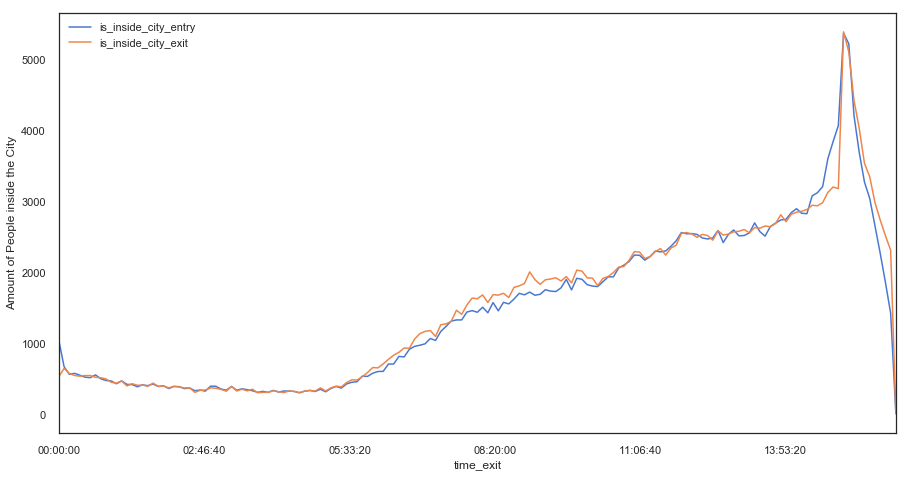

In [56]:
entry_avg_inside = train.set_index('time_entry').resample('0.1H').is_inside_city_entry.sum()
exit_avg_inside = train.set_index('time_exit').resample('0.1H').is_inside_city_exit.sum()

plot_avg_distance([entry_avg_inside, exit_avg_inside], figsize=(15, 17), title='Amount of People inside the City')

The most clear pattern that can be seen above is that great amounts of people are moving into the city center at the first morning hours, rapidly climbing to a peak past lunch time. As a hub of activity, which would include not only work, but overall physical structure and commerce, this pattern seems fitting of a city center.

Also there is seemingly a local pattern of people leaving the city center after midnight, which perhaps relates to night shifts and entertainment events that take part at the final hours of a day.

## Test Data: Quick Comparison
In order to keep consistency on our analysis, let's quickly look through our test dataset for major discrepancies.

In [57]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0')
test.head(10)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,11:43:17,11:50:17,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,-1.914508e+07
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,12:21:37,12:21:37,0.00,0.00,0.00,3.773199e+06,-1.914354e+07,3.773199e+06,-1.914354e+07
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,12:34:27,13:14:11,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,-1.911092e+07
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,13:25:33,13:43:13,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,-1.914465e+07
4,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_5,15:03:32,15:10:32,NaN,NaN,NaN,3.773118e+06,-1.914490e+07,NaN,NaN
5,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_0,08:08:23,08:20:08,17.29,17.29,17.29,3.771380e+06,-1.933274e+07,3.769933e+06,-1.934095e+07
6,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_6,12:08:23,12:13:24,NaN,NaN,NaN,3.771380e+06,-1.933274e+07,3.769983e+06,-1.934265e+07
7,000479418b5561ab694a2870cc04fd43_25,traj_000479418b5561ab694a2870cc04fd43_25_10,15:29:09,15:30:56,NaN,NaN,NaN,3.769978e+06,-1.934136e+07,NaN,NaN
8,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_1,08:45:05,08:50:33,NaN,NaN,NaN,3.760880e+06,-1.910042e+07,3.759312e+06,-1.908280e+07
9,000506a39775e5bca661ac80e3f466eb_29,traj_000506a39775e5bca661ac80e3f466eb_29_2,11:09:02,11:09:02,NaN,NaN,NaN,3.755349e+06,-1.916135e+07,3.755349e+06,-1.916135e+07


In [17]:
pandas_profiling.ProfileReport(test)

Number of variables,11
Number of observations,202937
Total Missing (%),8.1%
Total size in memory,18.6 MiB
Average record size in memory,96.0 B
Numeric,4
Categorical,3
Boolean,0
Date,0
Text (Unique),1
Rejected,3


The distribution observed on each variable at first doesn't present anything unusual. Let's repeat the `distance` creation and plotting to further investigate.

C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


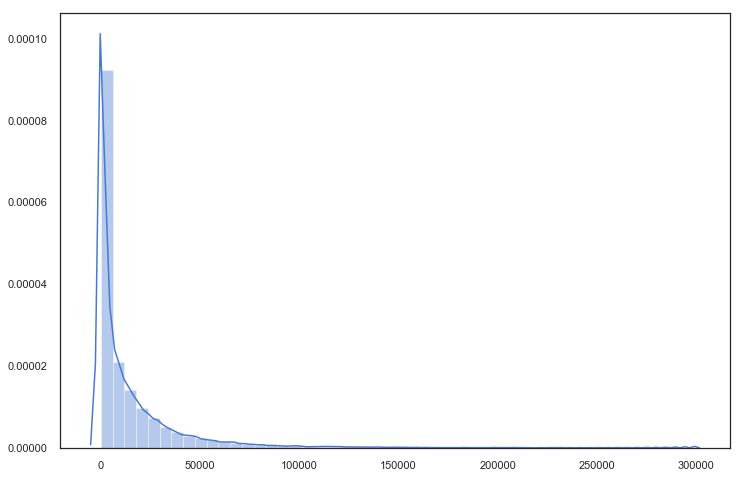

In [58]:
test['distance'] = euclidian_distance(test.x_entry.values, test.y_entry.values,
                                      test.x_exit.values, test.y_exit.values)

test_grouped = test.groupby('hash').distance

fig = plt.figure(figsize=(12, 8))
sns.set(style="white", palette="muted", color_codes=True)


sns.distplot(test_grouped.mean().dropna().values)

Minimum value for time_entry: 0 days 00:00:00
Maximum value for time_entry: 0 days 16:00:00
Minimum value for time_exit: 0 days 00:00:00
Maximum value for time_exit: 0 days 16:00:00


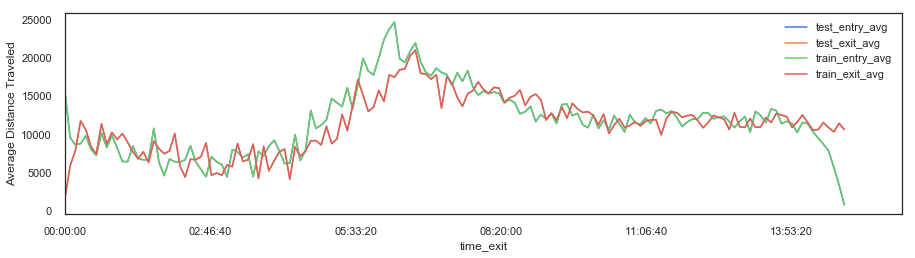

In [59]:
# transforming our time data to pandas timedelta format
test['time_entry'] = pd.to_timedelta(test.time_entry)
test['time_exit'] = pd.to_timedelta(test.time_exit)

print('Minimum value for time_entry: {}'.format(test.time_entry.min()))
print('Maximum value for time_entry: {}'.format(test.time_entry.max()))

print('Minimum value for time_exit: {}'.format(test.time_entry.min()))
print('Maximum value for time_exit: {}'.format(test.time_entry.max()))

test_entry_avg = test.set_index('time_entry').distance.resample('0.1H').mean()
test_exit_avg = test.set_index('time_exit').distance.resample('0.1H').mean()
train_entry_avg = test.set_index('time_entry').distance.resample('0.1H').mean()
train_exit_avg = test.set_index('time_exit').distance.resample('0.1H').mean()

avg_list = [test_entry_avg, test_exit_avg, train_entry_avg, train_exit_avg]
labels = ['test_entry_avg', 'test_exit_avg', 'train_entry_avg', 'train_exit_avg']
plot_avg_distance(avg_list, figsize=(15, 17), labels=labels)

Test and train set distributions here overlap in a pretty straightforward way. Now let's analyze the distribution of people inside the city center throughout a day's timespan.

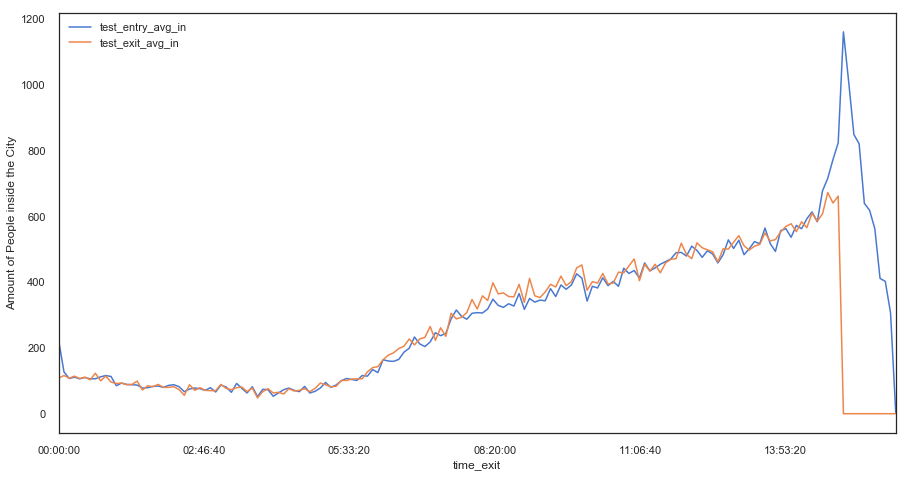

In [60]:
test['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(train.x_entry, test.y_entry)]
test['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(train.x_exit, test.y_exit)]

test_entry_avg_in = test.set_index('time_entry').resample('0.1H').is_inside_city_entry.sum()
test_exit_avg_in = test.set_index('time_exit').resample('0.1H').is_inside_city_exit.sum()

avg_list = [test_entry_avg_in, test_exit_avg_in]
labels = ['test_entry_avg_in', 'test_exit_avg_in']
plot_avg_distance(avg_list, figsize=(15, 17), title='Amount of People inside the City', labels=labels)

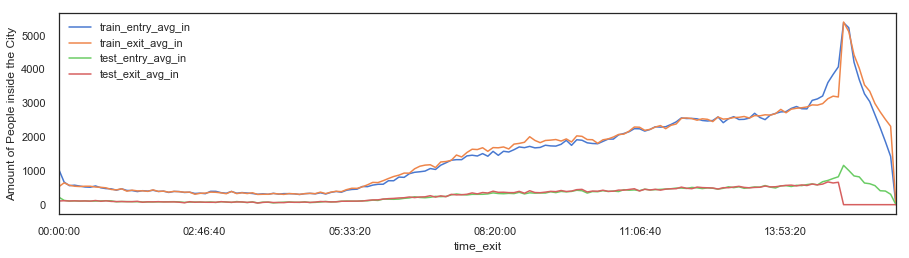

In [61]:
train_entry_avg_in = train.set_index('time_entry').resample('0.1H').is_inside_city_entry.sum()
train_exit_avg_in = train.set_index('time_exit').resample('0.1H').is_inside_city_exit.sum()

avg_list = [train_entry_avg_in, train_exit_avg_in, test_entry_avg_in, test_exit_avg_in]
labels = ['train_entry_avg_in', 'train_exit_avg_in', 'test_entry_avg_in', 'test_exit_avg_in']
plot_avg_distance(avg_list, figsize=(15, 17), title='Amount of People inside the City', labels=labels)

The overall consistency seems very solid - our test data follows closely the patterns seen in train data, both clearly samples of one same distribution.

The only major difference is the sudden drop observed in test set's exit average, which is logical: that's precisely what we're going to predict.

## Feature Engineering in-Depth
We can determine the centrality of the trajectories, by calculating how much closer or farther from the city center a given trajectory leads.

In [62]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

center['x_middle'] = center['x_min'] + (center['x_max'] - center['x_min'])/2
center['y_middle'] = center['y_min'] + (center['y_max'] - center['y_min'])/2

train['x_center_delta'] = abs(center['x_middle'] - train.x_exit.values) - abs(center['x_middle'] - train.x_entry.values)
train['y_center_delta'] = abs(center['y_middle'] - train.y_exit.values) - abs(center['y_middle'] - train.y_entry.values)

train.tail(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,distance,is_inside_city_entry,is_inside_city_exit,x_center_delta,y_center_delta
814258,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_5,06:02:17,06:02:17,NaN,NaN,NaN,3.744732e+06,-1.925614e+07,3.744732e+06,-1.925614e+07,0.000000,0,0,0.000000,0.000000
814259,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_7,09:52:13,09:52:13,NaN,NaN,NaN,3.744666e+06,-1.925679e+07,3.744666e+06,-1.925679e+07,0.000000,0,0,0.000000,0.000000
814260,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_8,14:20:26,14:27:15,NaN,NaN,NaN,3.741043e+06,-1.929051e+07,3.741057e+06,-1.928936e+07,1148.346741,0,0,-14.471534,-1148.255551
814261,ffffc6359725f0e1feac9ef1872ab207_11,traj_ffffc6359725f0e1feac9ef1872ab207_11_10,14:56:46,15:04:05,0.0,0.0,0.0,3.743948e+06,-1.923560e+07,3.744842e+06,-1.926218e+07,26598.563629,0,0,-893.895511,19974.895466


Let's explore this new variable's distribution throughout our data, grouping it by device IDs.

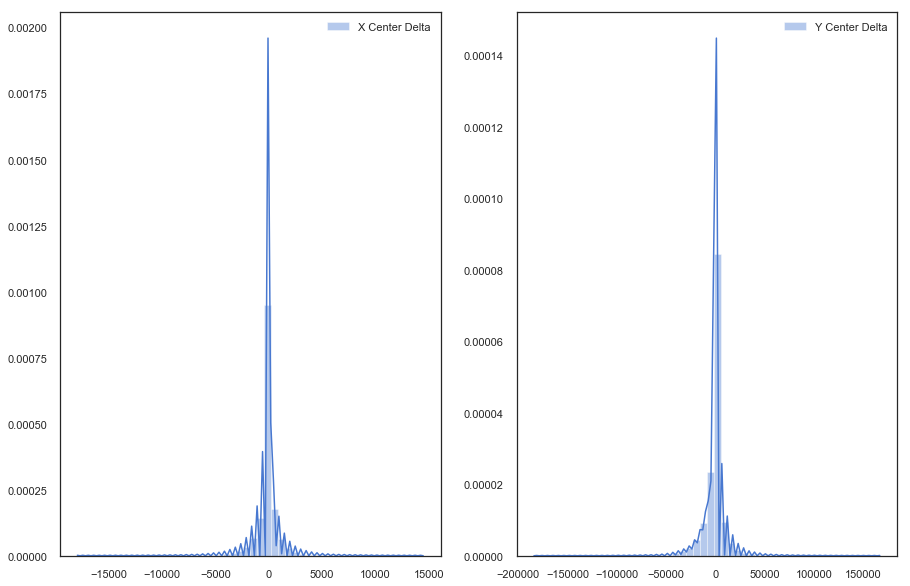

In [63]:
delta_grouped = { 'x': train.groupby('hash').x_center_delta, 'y': train.groupby('hash').y_center_delta }

fig, ax = plt.subplots(1,2, figsize=(15,10))
sns.set(style="white", palette="muted", color_codes=True)

sns.distplot(delta_grouped['x'].mean().dropna().values, ax=ax[0], label='X Center Delta')
sns.distplot(delta_grouped['y'].mean().dropna().values, ax=ax[1], label='Y Center Delta')

ax[0].legend()
ax[1].legend()

In [64]:
print('Δx Skewness: {}'.format(delta_grouped['x'].mean().skew()),
      'Δy Skewness: {}'.format(delta_grouped['y'].mean().skew()), sep='\t')

print('Δx Kurtosis: {}'.format(delta_grouped['x'].mean().kurtosis()),
      'Δy Kurtosis: {}'.format(delta_grouped['y'].mean().kurtosis()), sep='\t\t')

Δx Skewness: -0.9955468996904077	Δy Skewness: -1.2136082074436607
Δx Kurtosis: 18.69178305236969		Δy Kurtosis: 18.365812505236235


We can conclude both deltas present about the same distribution patterns: both leptokurtic, notably negatively skewed.

Also, a considerable portion of the data points are zeroed in at least one axis.

We can then explore distanciation from center throughout time.

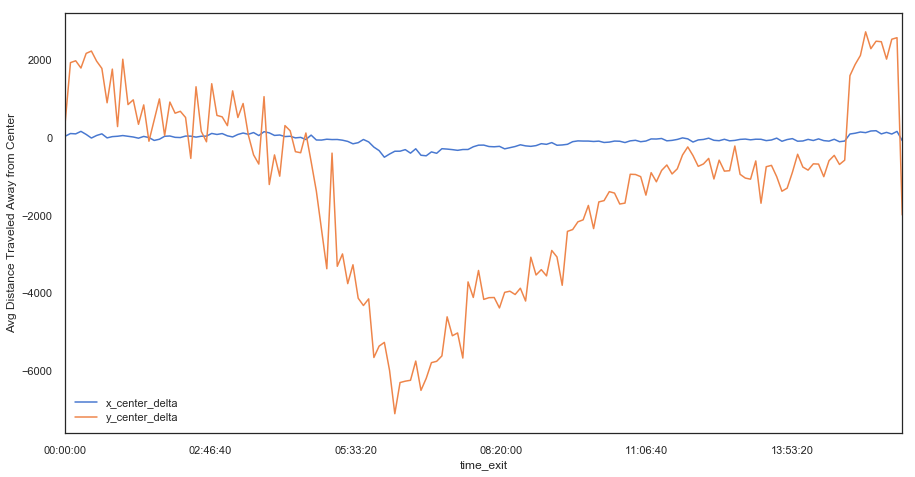

In [65]:
x_delta_avg = train.set_index('time_exit').x_center_delta.resample('0.1H').mean()
y_delta_avg = train.set_index('time_exit').y_center_delta.resample('0.1H').mean()

plot_avg_distance([x_delta_avg, y_delta_avg], figsize=(15, 17), title='Avg Distance Traveled Away from Center')

In the above plot we observe a very divergent behavior stemming from each trajectory axis. In comparison to vertical motion, distance from center is almost perfectly stable throughout the x-axis.

There is a clear valley - which represents approximation to the city center - building up in the morning close to 6 AM. That's likely related to the work routes leading mostly to the center of Atlanta. Let's check those values.

In [66]:
x_delta_avg.sort_values(ascending=True).head(10)

time_exit
06:06:00   -509.915167
06:54:00   -473.343978
06:48:00   -458.921315
06:12:00   -427.686593
07:06:00   -408.716670
06:36:00   -405.257817
07:00:00   -372.693118
06:18:00   -356.117871
06:24:00   -354.711016
06:00:00   -339.488798
Name: x_center_delta, dtype: float64

In [67]:
y_delta_avg.sort_values(ascending=True).head(10)

time_exit
06:18:00   -7110.553330
06:48:00   -6509.954639
06:24:00   -6308.441906
06:30:00   -6273.216952
06:36:00   -6250.247628
06:54:00   -6201.852438
06:12:00   -6001.299147
07:00:00   -5796.452872
07:06:00   -5762.129936
06:42:00   -5755.474246
Name: y_center_delta, dtype: float64

Although both axes show the same pattern in approximation through time, y-axis' absolute values are roughly one order of magnitude greater.

From the previous plot we can also conclude there's a distanciation peak in the middle of the afternoon, a bit higher than the other peak occuring right after midnight. The latter one is likely related to the end of night shifts for people who work closer to the center than where they live.

Let's see a few of those values.

In [68]:
x_delta_avg.sort_values(ascending=False).head(10)

time_exit
15:30:00    172.272156
15:24:00    165.092334
00:18:00    155.355640
15:54:00    154.385708
03:48:00    146.759371
15:12:00    138.946745
15:42:00    129.496735
03:36:00    124.818830
15:18:00    122.473981
03:54:00    117.110839
Name: x_center_delta, dtype: float64

In [69]:
y_delta_avg.sort_values(ascending=False).head(10)

time_exit
15:18:00    2716.869840
15:54:00    2566.281809
15:48:00    2526.867903
15:30:00    2476.382312
15:36:00    2462.426185
15:24:00    2283.880440
00:30:00    2222.173966
00:24:00    2162.552537
15:12:00    2108.688441
15:42:00    2014.595165
Name: y_center_delta, dtype: float64

Distanciation/approximation measuring can probably be more useful if we can regularize it, so that:
- approximation is weighed proportionally to how close the entry points are from the center;
- distanciation is weighed proportionally to how far the entry points are from the center.

In [70]:
def dist_to_center(condition, middle_prop, entry, df):
    dist = abs( center[middle_prop] - df[condition][entry].values )
    return dist / dist.max()


# conditionable distances
x_to_center = lambda condition: dist_to_center(condition, 'x_middle', 'x_entry', train)
y_to_center = lambda condition: dist_to_center(condition, 'y_middle', 'y_entry', train)

In [71]:
# conditions
x_is_closer = train.x_center_delta.values < 0
y_is_closer = train.y_center_delta.values < 0
x_is_farther = train.x_center_delta.values > 0
y_is_farther = train.y_center_delta.values > 0

# approximation regularization: inversely proportional to distance
train.loc[x_is_closer, 'x_center_delta'] *= (1 - x_to_center(x_is_closer))
train.loc[y_is_closer, 'y_center_delta'] *= (1 - y_to_center(y_is_closer))

# distanciation regularization: directly proportional to distance
train.loc[x_is_farther, 'x_center_delta'] *= x_to_center(x_is_farther)
train.loc[y_is_farther, 'y_center_delta'] *= y_to_center(y_is_farther)

C:\Users\julio\Anaconda3\envs\eygeo\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


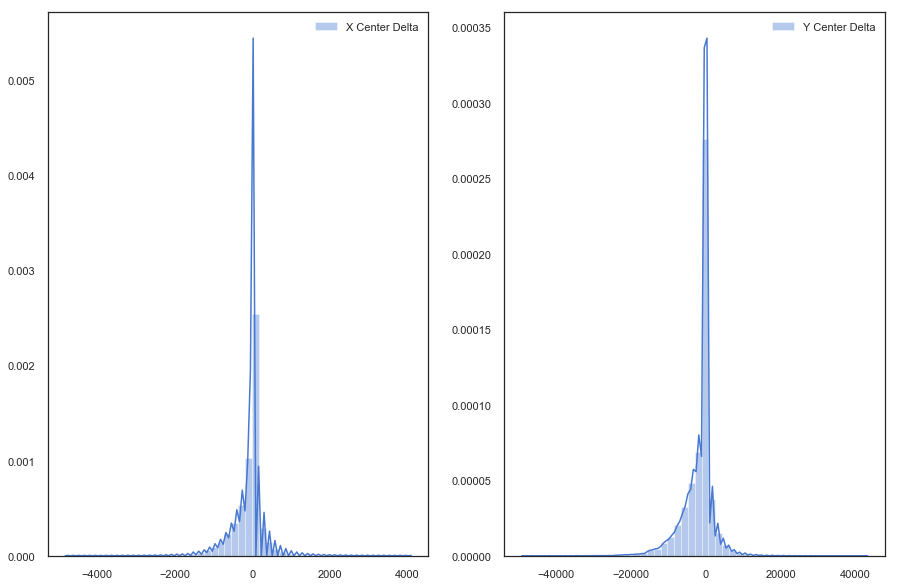

In [72]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
sns.set(style="white", palette="muted", color_codes=True)

sns.distplot(delta_grouped['x'].mean().dropna().values, ax=ax[0], label='X Center Delta')
sns.distplot(delta_grouped['y'].mean().dropna().values, ax=ax[1], label='Y Center Delta')

ax[0].legend()
ax[1].legend()

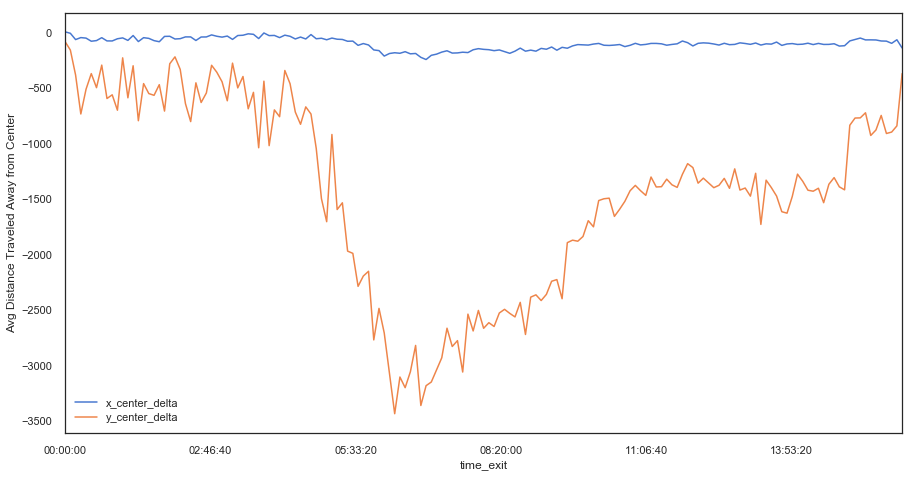

In [73]:
x_delta_avg = train.set_index('time_exit').x_center_delta.resample('0.1H').mean()
y_delta_avg = train.set_index('time_exit').y_center_delta.resample('0.1H').mean()

plot_avg_distance([x_delta_avg, y_delta_avg], figsize=(15, 17), title='Avg Distance Traveled Away from Center')

In [74]:
print('Δx Skewness: {}'.format(delta_grouped['x'].mean().skew()),
      'Δy Skewness: {}'.format(delta_grouped['y'].mean().skew()), sep='\t')

print('Δx Kurtosis: {}'.format(delta_grouped['x'].mean().kurtosis()),
      'Δy Kurtosis: {}'.format(delta_grouped['y'].mean().kurtosis()), sep='\t\t')

Δx Skewness: -1.3025432478915715	Δy Skewness: -1.629621444763087
Δx Kurtosis: 10.246297827021028		Δy Kurtosis: 9.384118410088215


From the above series of info, it is clear the overall distributions of both deltas has smoothed out: there was a significant drop in kurtosis for both, nearly 50%.

And most notably, both the previously positive y-axis peaks from midnight and mid-afternoon have shifted down, which signals to relations with entry points closer to the city center.

Trajectory isn't only geared towards distances traveled, but also towards time taken. Let's use the timedelta converted entry/exit times to calculate the mean trajectory timespan.

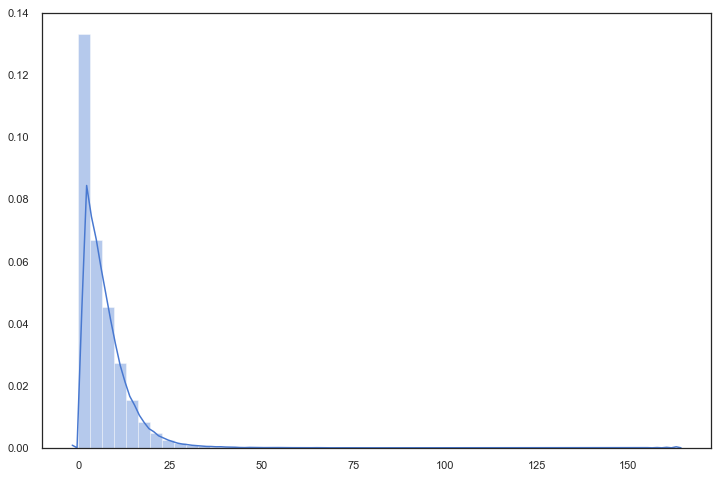

In [75]:
train['trajectory_time'] = (train.time_exit - train.time_entry) / np.timedelta64(1, 'm')

train_grouped = train.groupby('hash').trajectory_time

fig = plt.figure(figsize=(12, 8))
sns.set(style="white", palette="muted", color_codes=True)

sns.distplot(train_grouped.mean().values)

## Central Permanency Density

Currently it is inferable if any (entry or exit) point is inside the city center. Yet, trajectories denote a linear segment - it could prove useful to know percentually how much of a trajectory segment falls inside Atlanta's center.

**So, we want to determine the _existence and value_ of intersections between trajectories and the city center's edges.**

For that to be done, we must dig into the geometrical math that supports our goals.

Let's first consider two line segments:
- $T$, the **trajectory** line segment that goes from $(x_1,y_1)$ to $(x_2,y_2)$
- $E$, the **edge** line segment that goes from $(x_3,y_3)$ to $(x_4,y_4)$

The interval between $(x_1,y_1)$ and $(x_2,y_2)$ in $T$ can be seen simply as $(x_1,y_1) + (x_2,y_2)u$, where $u$ is a scalar in $[0,1]$.

Isolating that sum in each axis of $T$, we'll have:
$$T = \{ (x_1 + (x_2-x_1)u,y_1 + (y_2-y_1)u) \in \mathbb R^2 \mid u \in [0,1] \}$$

And for $E$, where $v$ is the scalar factor:
$$E = \{ (x_3 + (x_4-x_3)v, y_3 + (y_4-y_3)v) \in \mathbb R^2 \mid v \in [0,1] \}$$

We want to find $T \cap E$, if existant. That means finding $u \in [0,1]$, $v \in [0,1]$ such that $$(x_1 + (x_2-x_1)u,y_1 + (y_2-y_1)u)=(x_3 + (x_4-x_3)v,y_3 + (y_4-y_3)v)$$

Splitting that equality among axes, we'd get

$$x_1 + (x_2-x_1)u=x_3 + (x_4-x_3)v$$

$$y_1 + (y_2-y_1)u=y_3 + (y_4-y_3)v$$

And by isolating $v$ in both axis equalities above, we can then solve for $u$ with

$$\frac{(x_1-x_3) + (x_2-x_1)u}{(x_4-x_3)}=\frac{(y_1-y_3) + (y_2-y_1)u}{(y_4-y_3)}$$

$$\frac{(y_4-y_3)(x_1-x_3) - (x_4-x_3)(y_1-y_3)}{(x_4-x_3)(y_2-y_1) - (y_4-y_3)(x_2-x_1)} = u$$

After having $u$ calculated through the above formula, we'd have all we need to know where in $T$ the intersection happens.

Repeating that process for each city center edge, and for each trajectory vector, we can know exactly when and with which values do intersections with the center occur. Let's now make the explained math runnable:

In [89]:
from shapely.geometry import LineString, Polygon, mapping

center_polygon = Polygon([(center['x_min'], center['y_min']), (center['x_min'], center['y_max']),
                          (center['x_max'], center['y_min']), (center['x_max'], center['y_max'])])
center_edges = list(zip(*center_polygon.exterior.coords.xy))

def intersects_center(x, y):
    return LineString([(x[0], y[0]), (x[1], y[1])]).intersects(center_polygon)

def has_intersection(xa, ya, xb, yb):
    line_a = LineString([(xa[0], ya[0]), (xa[1], ya[1])])
    line_b = LineString([(xb[0], yb[0]), (xb[1], yb[1])])
    return line_a.intersects(line_b)

def central_permanency_density(xa, ya, distance, entry_inside_center):
    if not intersects_center(xa, ya):
        if entry_inside_center:
            # trajectory stayed inside center
            return 1
        else:
            # trajectory stayed outside center
            return 0

    x_intersections = []
    y_intersections = []
    for x1, y1, x2, y2 in zip(center_edges[:-1], center_edges[1:]):
        # edge cartesian vectors
        xb, yb = [x1, x2], [y1, y2]

        if has_intersection(xa, ya, xb, yb):
            dya = ya[1] - ya[0]
            dxa = xa[1] - xa[0]
            dxb = xb[1] - xb[0]
            dyb = yb[1] - yb[0]

            numerator = dyb * (xa[0] - xb[0]) - dxb * (ya[0] - yb[0])
            denominator = dxb * dya - dyb * dxa
            a_factor = numerator / denominator

            xa_intersected = xa[0] + dxa * a_factor
            ya_intersected = ya[0] + dya * a_factor
            x_intersections.append(xa_intersected)
            y_intersections.append(xa_intersected)

    x_distance = abs(xa[1] - xa[0])
    y_distance = abs(ya[1] - ya[0])

    if len(x_intersections) == 1:
        # intersects with only one edge of the city center
        if entry_inside_center:
            trajectory_x_density = abs(x_intersections[0] - xa[0]) / x_distance
            trajectory_y_density = abs(y_intersections[0] - ya[0]) / y_distance
            trajectory_density = euclidian_distance(xa[0], ya[0], x_intersections[0], y_intersections[0]) / distance
        else:
            trajectory_x_density = abs(xa[1] - x_intersections[0]) / x_distance
            trajectory_y_density = abs(ya[1] - y_intersections[0]) / y_distance
            trajectory_density = euclidian_distance(x_intersections[0], y_intersections[0], xa[1], ya[1]) / distance
    else:
        # intersects with two edges (only scenario left for linear trajectories)
        trajectory_x_density = abs(x_intersections[1] - x_intersections[0]) / x_distance
        trajectory_y_density = abs(y_intersections[1] - y_intersections[0]) / y_distance
        trajectory_density = euclidian_distance(x_intersections[0], y_intersections[0],
                                                x_intersections[1], y_intersections[1]) / distance

    return (trajectory_density, trajectory_x_density, trajectory_y_density)

## Simple Feature Extraction
Feature calculations already provided by default can be easily plugged into the DataFrame with the help of brief scripting, as follows:

In [309]:
distance_timetrajectory_features = (train
                                    .groupby(['hash', 'trajectory_id', 'time_entry'])[['distance', 'trajectory_time']]
                                    .mean()
                                    .shift(1)
                                    .rolling(5, min_periods=1)
                                    .agg(['mean', 'max', 'std', 'min', 'sum']))
distance_timetrajectory_features.head(5)

distance  \
                                                                                                 mean   
hash                               trajectory_id                             time_entry                 
0000a8602cf2def930488dee7cdad104_1 traj_0000a8602cf2def930488dee7cdad104_1_0 07:04:31             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_1 07:20:34    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_2 07:53:32    22677.253373   
                                   traj_0000a8602cf2def930488dee7cdad104_1_3 08:17:50    15360.055102   
                                   traj_0000a8602cf2def930488dee7cdad104_1_4 14:38:09    11971.185539   

                                                                                                       \
                                                                                                  max   
hash                               trajectory_id                             time_entry                 
0000a8602cf2def930488dee7cdad104_1 traj_0000a8602cf2def930488dee7cdad104_1_0 07:04:31             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_1 07:20:34    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_2 07:53:32    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_3 08:17:50    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_4 14:38:09    42364.863118   

                                                                                                       \
                                                                                                  std   
hash                               trajectory_id                             time_entry                 
0000a8602cf2def930488dee7cdad104_1 traj_0000a8602cf2def930488dee7cdad104_1_0 07:04:31             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_1 07:20:34             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_2 07:53:32    27842.484712   
                                   traj_0000a8602cf2def930488dee7cdad104_1_3 08:17:50    23414.229628   
                                   traj_0000a8602cf2def930488dee7cdad104_1_4 14:38:09    20283.536354   

                                                                                                       \
                                                                                                  min   
hash                               trajectory_id                             time_entry                 
0000a8602cf2def930488dee7cdad104_1 traj_0000a8602cf2def930488dee7cdad104_1_0 07:04:31             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_1 07:20:34    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_2 07:53:32     2989.643628   
                                   traj_0000a8602cf2def930488dee7cdad104_1_3 08:17:50      725.658561   
                                   traj_0000a8602cf2def930488dee7cdad104_1_4 14:38:09      725.658561   

                                                                                                       \
                                                                                                  sum   
hash                               trajectory_id                             time_entry                 
0000a8602cf2def930488dee7cdad104_1 traj_0000a8602cf2def930488dee7cdad104_1_0 07:04:31             NaN   
                                   traj_0000a8602cf2def930488dee7cdad104_1_1 07:20:34    42364.863118   
                                   traj_0000a8602cf2def930488dee7cdad104_1_2 07:53:32    45354.506746   
                                   traj_0000a8602cf2def930488dee7cdad104_1_3 08:17:50    46080.1653

In [310]:
distance_timetrajectory_features.columns = ["_".join(x) 
                                            for x in distance_timetrajectory_features.columns.ravel()]

In [311]:
train = train.merge(distance_timetrajectory_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
train.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_mean_y,distance_max_y,distance_std_y,distance_min_y,distance_sum_y,trajectory_time_mean_y,trajectory_time_max_y,trajectory_time_std_y,trajectory_time_min_y,trajectory_time_sum_y
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,42364.863118,42364.863118,NaN,42364.863118,42364.863118,4.016667,4.016667,NaN,4.016667,4.016667
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,22677.253373,42364.863118,27842.484712,2989.643628,45354.506746,4.575000,5.133333,0.789603,4.016667,9.150000
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,15360.055102,42364.863118,23414.229628,725.658561,46080.165307,6.344444,9.883333,3.115211,4.016667,19.033333


Given the previous calculation over x deltas and y deltas, here we'll calculate directly the entry points' distances (vector norms) w.r.t the city center.

In [312]:
train['last_distance'] = train.distance.shift(1)

In [313]:
train['timedelta_in_minutes'] = (train.time_exit - train.time_entry) / np.timedelta64(1, 'm')

In [314]:
train['distance_from_center'] = np.sqrt(((train.x_entry.values-center['x_middle'])**2) +
                                        ((train.y_entry.values-center['y_middle'])**2))

In [315]:
train.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_mean_y,distance_max_y,distance_std_y,distance_min_y,distance_sum_y,trajectory_time_mean_y,trajectory_time_max_y,trajectory_time_std_y,trajectory_time_min_y,trajectory_time_sum_y
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,42364.863118,42364.863118,NaN,42364.863118,42364.863118,4.016667,4.016667,NaN,4.016667,4.016667
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,22677.253373,42364.863118,27842.484712,2989.643628,45354.506746,4.575000,5.133333,0.789603,4.016667,9.150000
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,15360.055102,42364.863118,23414.229628,725.658561,46080.165307,6.344444,9.883333,3.115211,4.016667,19.033333


In [316]:
three_oclock = pd.to_timedelta('15:00:00')
four_oclock = pd.to_timedelta('16:00:00')

data_train = train[(train.time_exit >= three_oclock) & (train.time_exit <= four_oclock)].copy()

In [ ]:
train.columns.tolist()

In [295]:
data_train = data_train.fillna(value=0)

features = ['vmax',
            'vmin',
            'vmean',
            'x_entry',
            'y_entry',
            'is_inside_city_entry',
            'distance_mean',
            'distance_max',
            'distance_std',
            'distance_min',
            'distance_sum',
            'trajectory_time_mean',
            'trajectory_time_max',
            'trajectory_time_std',
            'trajectory_time_min',
            'trajectory_time_sum',
            'distance_from_center',
            'timedelta_in_minutes',
            'last_distance']

target = ['is_inside_city_exit']

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier

dt_train, dt_test = train_test_split(data_train, test_size=0.20, random_state=20)
dt_train.shape, dt_test.shape

((107250, 40), (26813, 40))

In [297]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(LGBMClassifier(n_estimators=150))
pipeline.fit(dt_train[features], dt_train[target])

C:\Users\julio\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\julio\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('lgbmclassifier', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [298]:
from sklearn.metrics import f1_score, r2_score

preds = pipeline.predict(dt_test[features])

f1_score(dt_test[target], preds)

0.8779102782509937

In [192]:
# raw deltas
test['x_center_delta'] = abs(center['x_middle'] - test.x_exit.values) - abs(center['x_middle'] - test.x_entry.values)
test['y_center_delta'] = abs(center['y_middle'] - test.y_exit.values) - abs(center['y_middle'] - test.y_entry.values)

# conditions
x_is_closer = test.x_center_delta.values < 0
y_is_closer = test.y_center_delta.values < 0
x_is_farther = test.x_center_delta.values > 0
y_is_farther = test.y_center_delta.values > 0

# conditionable distances
x_to_center = lambda condition: dist_to_center(condition, 'x_middle', 'x_entry', test)
y_to_center = lambda condition: dist_to_center(condition, 'y_middle', 'y_entry', test)

# approximation regularization: inversely proportional to distance
test.loc[x_is_closer, 'x_center_delta'] *= (1 - x_to_center(x_is_closer))
test.loc[y_is_closer, 'y_center_delta'] *= (1 - y_to_center(y_is_closer))

# distanciation regularization: directly proportional to distance
test.loc[x_is_farther, 'x_center_delta'] *= x_to_center(x_is_farther)
test.loc[y_is_farther, 'y_center_delta'] *= y_to_center(y_is_farther)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [193]:
test['time_entry'] = pd.to_timedelta(test.time_entry)
test['time_exit'] = pd.to_timedelta(test.time_exit)
test['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(test.x_entry, test.y_entry)]
test['distance'] = euclidian_distance(test.x_entry.values, test.y_entry.values, 
                                       test.x_exit.values, test.y_entry.values)

test['timedelta_in_minutes'] = (test.time_exit - test.time_entry) / np.timedelta64(1, 'm')
test['last_timedelta_in_minutes'] = test['timedelta_in_minutes'].shift(1)
test['last_distance'] = test.distance.shift(1)
test['distance_from_center'] = np.sqrt(((test.x_entry.values-center['x_middle'])**2) +
                                       ((test.y_entry.values-center['y_middle'])**2))

test['trajectory_time'] = (test.time_exit - test.time_entry) / np.timedelta64(1, 'm')

In [200]:
distance_timetrajectory_features = (test
                                    .groupby(['hash', 'trajectory_id', 'time_entry'])
                                        [['distance', 'trajectory_time', 'x_center_delta', 'y_center_delta']]
                                    .mean()
                                    .shift(1)
                                    .rolling(5, min_periods=1)
                                    .agg(['mean', 'max', 'std', 'min', 'sum']))
distance_timetrajectory_features.head(5)

distance  \
                                                                                                  mean   
hash                                trajectory_id                              time_entry                
00032f51796fd5437b238e3a9823d13d_31 traj_00032f51796fd5437b238e3a9823d13d_31_0 11:43:17            NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_2 12:21:37     302.789015   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_3 12:34:27     151.394507   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_4 13:25:33    2766.660411   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_5 15:03:32    2138.447418   

                                                                                                        \
                                                                                                   max   
hash                                trajectory_id                              time_entry                
00032f51796fd5437b238e3a9823d13d_31 traj_00032f51796fd5437b238e3a9823d13d_31_0 11:43:17            NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_2 12:21:37     302.789015   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_3 12:34:27     302.789015   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_4 13:25:33    7997.192219   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_5 15:03:32    7997.192219   

                                                                                                        \
                                                                                                   std   
hash                                trajectory_id                              time_entry                
00032f51796fd5437b238e3a9823d13d_31 traj_00032f51796fd5437b238e3a9823d13d_31_0 11:43:17            NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_2 12:21:37            NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_3 12:34:27     214.104166   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_4 13:25:33    4532.302675   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_5 15:03:32    3908.083667   

                                                                                                       \
                                                                                                  min   
hash                                trajectory_id                              time_entry               
00032f51796fd5437b238e3a9823d13d_31 traj_00032f51796fd5437b238e3a9823d13d_31_0 11:43:17           NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_2 12:21:37    302.789015   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_3 12:34:27      0.000000   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_4 13:25:33      0.000000   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_5 15:03:32      0.000000   

                                                                                                        \
                                                                                                   sum   
hash                                trajectory_id                              time_entry                
00032f51796fd5437b238e3a9823d13d_31 traj_00032f51796fd5437b238e3a9823d13d_31_0 11:43:17            NaN   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_2 12:21:37     302.789015   
                                    traj_00032f51796fd5437b238e3a9823d13d_31_3 12:34:27     302.789015   
                                    traj_00032f51796fd5437b238e3a9823d

In [201]:
distance_timetrajectory_features.columns = ["_".join(x) 
                                            for x in distance_timetrajectory_features.columns.ravel()]

In [202]:
test = test.merge(distance_timetrajectory_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
test.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,x_center_delta_mean,x_center_delta_max,x_center_delta_std,x_center_delta_min,x_center_delta_sum,y_center_delta_mean,y_center_delta_max,y_center_delta_std,y_center_delta_min,y_center_delta_sum
0,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_0,11:43:17,11:50:17,NaN,NaN,NaN,3.773413e+06,-1.909828e+07,3.773111e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_2,12:21:37,12:21:37,0.0,0.0,0.0,3.773199e+06,-1.914354e+07,3.773199e+06,...,-112.026813,-112.026813,NaN,-112.026813,-112.026813,-12729.075694,-12729.075694,NaN,-12729.075694,-12729.075694
2,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_3,12:34:27,13:14:11,NaN,NaN,NaN,3.763760e+06,-1.921342e+07,3.771757e+06,...,-56.013406,0.000000,79.214919,-112.026813,-112.026813,-6364.537847,0.000000,9000.815741,-12729.075694,-12729.075694
3,00032f51796fd5437b238e3a9823d13d_31,traj_00032f51796fd5437b238e3a9823d13d_31_4,13:25:33,13:43:13,NaN,NaN,NaN,3.773385e+06,-1.911344e+07,3.773131e+06,...,347.016689,1153.076878,700.312269,-112.026813,1041.050066,303.986545,13641.035328,13187.683447,-12729.075694,911.959634


In [203]:
data_test = test[test.x_exit.isnull()].copy()
data_test = data_test.fillna(value=0.0)

In [204]:
pipeline.fit(data_train[features], data_train[target])

C:\Users\julio\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\julio\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('lgbmclassifier', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [ ]:
preds_oficial = pipeline.predict(data_test[features])

In [130]:
pd.Series(preds_oficial).value_counts()

0    24297
1     9218
dtype: int64

In [131]:
submission = pd.DataFrame(list(zip(data_test.trajectory_id, preds_oficial)), columns=['id', 'target'])

In [132]:
submission.to_csv('../data/submission.csv', index=False)

In [ ]:
list(zip(data_train[features].columns, pipeline.steps[0][1].feature_importances_))